In [1]:
from modules.resnet import Node
from modules.resnet import ResNet
from modules.mcts import MCTS
from modules.alphazero import AlphaZeroParallel

from modules.game.gomoku import Gomoku
from modules.game.tictactoe import TicTacToe
from modules.game.connectfour import ConnectFour

import matplotlib.pyplot as plt
import torch
import numpy as np

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.__version__, device

('2.0.1', device(type='cpu'))

-0.09683775901794434
[[ 0.  0. -1.  0. -1.]
 [ 0.  1.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
tensor([[[[0., 0., 1., 0., 1.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]],

         [[1., 1., 0., 1., 0.],
          [1., 0., 1., 0., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]],

         [[0., 0., 0., 0., 0.],
          [0., 1., 0., 1., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]]])


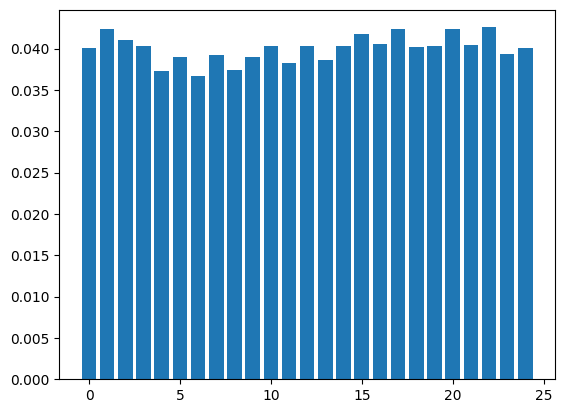

In [2]:
game = Gomoku()

state = game.get_initial_state()
state = game.get_next_state(state, 2, -1)
state = game.get_next_state(state, 4, -1)
state = game.get_next_state(state, 6, 1)
state = game.get_next_state(state, 8, 1)

encoded_state = game.get_encoded_state(state)
tensor_state = torch.tensor(encoded_state, device=device).unsqueeze(0)

model = ResNet(game, 4, 64, device=device)
# model.load_state_dict(torch.load('model_2.pt', map_location=device))
model.eval()

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

print(value)
print(state)
print(tensor_state)

plt.bar(range(game.action_size), policy)
plt.show()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(game, 4, 64, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

args = {
    'C': 2,
    'num_searches': 60,
    'num_iterations': 3,
    'num_selfPlay_iterations': 500,
    'num_parallel_games': 100,
    'num_epochs': 4,
    'batch_size': 64,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}

alphaZero = AlphaZeroParallel(model, optimizer, game, args)
alphaZero.learn()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
def play_game(game, args, player=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ResNet(game, 4, 64, device)
    model.load_state_dict(torch.load(f"models/{game}/model_{args['C']}.pt", map_location=device))
    model.eval()

    mcts = MCTS(game, args, model)
    state = game.get_initial_state()

    while True:
        print(state)
        
        if player == 1:
            valid_moves = game.get_valid_moves(state)
            print("valid_moves", [i for i in range(game.action_size) if valid_moves[i] == 1])
            action = int(input(f"{player}:"))

            if valid_moves[action] == 0:
                print("action not valid")
                continue
                
        else:
            neutral_state = game.change_perspective(state, player)
            mcts_probs = mcts.search(neutral_state)
            action = np.argmax(mcts_probs)
            
        state = game.get_next_state(state, action, player)
        
        value, is_terminal = game.get_value_and_terminated(state, action)
        
        if is_terminal:
            print(state)
            if value == 1:
                print(player, "won")
            else:
                print("draw")
            break
            
        player = game.get_opponent(player)

In [5]:
play_game(Gomoku(), {
    'C': 2,
    'num_searches': 1000,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
})

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  1.  0.  0.]
 [ 0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.]
 [ 1.  0.  1.  0.  0.]
 [ 0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.]
 [ 1.  0.  1.  0.  1.]
 [ 0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.]
 [ 1.  0.  1. -1.  1.]